# Проект: Выявление профилей потребления

# Введение

Цели и задачи проекта: 
   - Сегментировать покупателей по профилю потребления для осуществления рекламных рассылок
   - Дать подробные рекоммендации заказчику по сегментам покупателей

 Данные: Транзакции покупателей интернет-магазина:  
 - date — дата заказа;
 - customer_id — идентификатор покупателя; 
 - order_id — идентификатор заказа; 
 - product — наименование товара;
 - quantity — количество товара в заказе;
 - price — цена товара.

Загрузка необходимых библиотек:

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans
from scipy import stats as st
from scipy.stats import kruskal
from scipy.stats import mannwhitneyu
from itertools import combinations

C:\anaconda3\envs\practicum\lib\site-packages\sklearn\utils\fixes.py:28: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version  # type: ignore


## Предобработка данных

In [2]:
data=pd.read_csv('https://code.s3.yandex.net/datasets/ecom_dataset_upd.csv')
pd.options.display.max_colwidth = 75
data.head()

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         7474 non-null   int64  
 1   customer_id  7474 non-null   object 
 2   order_id     7474 non-null   int64  
 3   product      7474 non-null   object 
 4   quantity     7474 non-null   int64  
 5   price        7474 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 350.5+ KB


In [4]:
data.describe()

,date,order_id,quantity,price
count,7.474000e+03,7474.000000,7474.000000,7474.000000
mean,2.018913e+09,49449.884265,2.362858,478.737501
std,4.278878e+05,32679.642404,14.500497,901.615895
min,2.018100e+09,12624.000000,1.000000,9.000000
25%,2.019022e+09,14833.000000,1.000000,97.000000
50%,2.019051e+09,68768.000000,1.000000,135.000000
75%,2.019063e+09,71257.750000,1.000000,439.000000
max,2.020013e+09,112789.000000,1000.000000,14917.000000


- В данных присутствует 7474 записей, предварительно в данных нет пропусков. 
- Требуется преобразование типа данных для даты. 
- В количественных параметрах уже видны аномальные значения, например максимальное количество позиций товара в заказе 100, при среднем 2.4. 
- Также уже предварительно видно, что распределение данные ненормальное, стандартное отклонение сильно больше среднего, что также указывает на выбросы в данных.

### Проверка на пропуски в данных

In [5]:
data.isna().sum()

date           0
customer_id    0
order_id       0
product        0
quantity       0
price          0
dtype: int64

Пропусков в данных не обнаружено.

### Изменение типов данных

In [6]:
data['date'] = data['date'] // 100
data['date'] = pd.to_datetime(data['date'], format='%Y%m%d')

Из данных Даты убраны последние две цифры, обозначающие часы, также данные приведены к типу datetime

### Проверка на дубликаты

In [7]:
(data.drop(['date'], axis=1)).duplicated().sum()

1864

Обнаружено 1864 дубликатов без учета даты покупки

In [8]:
duplicates = data.drop(['date'], axis=1).duplicated(keep=False)
data[duplicates].sort_values(by='product').head(6)

,date,customer_id,order_id,product,quantity,price
2021,2019-02-25,075873aa-644c-4a09-9253-204f3156ac7b,70438,"Ёрш унитазный с деревянной ручкой , Ваир 1712012",20,56.0
1999,2019-02-25,075873aa-644c-4a09-9253-204f3156ac7b,70438,"Ёрш унитазный с деревянной ручкой , Ваир 1712012",20,56.0
3256,2019-04-28,cce13789-408b-44e1-8147-3c74dc393bf1,14701,Агератум рассада однолетних цветов в кассете по 10 шт,2,210.0
3306,2019-04-29,cce13789-408b-44e1-8147-3c74dc393bf1,14701,Агератум рассада однолетних цветов в кассете по 10 шт,2,210.0
4729,2019-06-06,6a86cc77-ef15-496f-b5d3-89005597ee5d,14856,Алиссум Скальный желтый объем 1 л,1,105.0
4754,2019-06-07,6a86cc77-ef15-496f-b5d3-89005597ee5d,14856,Алиссум Скальный желтый объем 1 л,1,105.0


На этом примере видны очевидные дубликаты позиций одного и того же заказа, но с разными датами, тем самым позиции в данных учитывались дважды. Данные дубликаты необходимо удалить. Рекоммендуется дополнительно выяснить происхождение данных дубликатов.

In [9]:
data = data.drop_duplicates(subset=data.columns.difference(['date']))
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5610 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         5610 non-null   datetime64[ns]
 1   customer_id  5610 non-null   object        
 2   order_id     5610 non-null   int64         
 3   product      5610 non-null   object        
 4   quantity     5610 non-null   int64         
 5   price        5610 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 306.8+ KB


Все дубликаты удалены.

In [10]:
data.duplicated().sum()

0

После проверки на полные дубликаты по всем параметрам данных дубликатов более не обнаружено.

Необходимо убедиться, что у заказов не задвоены покупатели.

In [11]:
bad_orders = data.groupby('order_id')['customer_id'].nunique()
bad_orders = bad_orders[bad_orders > 1]
bad_orders.count()

29

Обнаружено 29 заказов, которым присвоено более одного покупателя. Такого быть не может, необходимо удалить эти заказы.

In [12]:
data = data[~data['order_id'].isin(bad_orders.index)]
((7474-len(data))/7474)*100

25.82285255552582

Дубликаты и некорректные заказы удалены, т.о. удалено 26% данных.

### Обогащение данных

In [13]:
#создание явной копии очищенного dataframe для последующего анализа
df = data.copy().reset_index(drop=True)

In [14]:
#добавленице столбца с выручкой
df['revenue']=df['quantity']*df['price']

In [15]:
#добавление столбца с месяцем и годом покупки
df['year_month'] = df['date'].dt.strftime('%Y-%m')

В данные добалены два столбца с выручкой и месяцем и годом покупки для дальнейшео анализа.

#### Разделение товаров по категориям

In [17]:
categories = {
    'бытовая техника': [
        'весы', 'кипятильник', 'мантоварка', 'миксер', 'овощеварка', 'пылесос', 'соковарка', 'утюг', 'фен', 'Электроштопор'
    ],

    'бытовая химия, уборка': [
        'антижир', 'веник', 'губка', 'дозатор для мыла', 'ерш', 'зубная', 'мыло', 'налет', 'отбеливатель',
        'паста', 'перчатки', 'пена для ванн', 'порош', 'совок', 'средство для чистк', 'тряпка', 'чистк',
        'чистящ', 'швабр', 'щетка', 'ёрш', 'для мытья', 'мыльница', 'совок', 'совк', 'вантуз', 'скребок', 'засор', 
        'средство', 'стирк', 'мойк', 'ведр', 'для белья', 'Маска'
    ],


    'комнатные растения': [
        'адиантум', 'азалия', 'антуриум', 'артемизия', 'аспарагус', 'афеляндра', 'бегония', 'герань',
        'гербера', 'глоксиния', 'гортензия', 'дендробиум', 'душица', 'эвкалипт', 'жасмин', 'иссоп', 'капсикум',
        'калатея', 'каланхое', 'каллуна', 'кампанула', 'кориандр', 'лузеана', 'мелисса', 'мимоза',
        'мирт', 'молодило', 'нолина', 'пахира', 'пеларгония', 'примула', 'радермахера',
        'розмарин', 'роза', 'сантолина', 'суккулент', 'соланум', 'фигламен', 'фиалка', 'фикус',
        'флокс', 'фуксия', 'хлорофитум', 'хризантема', 'хризолидокарпус лутесценс', 'циперус зумула',
        'цикламен', 'юкка', 'эхеверия', 'эхинокактус', 'Комнатное растение', 'горшок', 'овогоднее дерево',
        'альбука спиралис фризл-сизл', 'бальзамин', 'крассула', 'калоцефалус', 'пуансеттия', 'бакопа', 'декабрист',
        'кофе', 'кашпо', 'горшк', 'Алоэ Вера', 'Аптения', 'Гардения', 'Драцена фрагранс', 'Замиокулькас', 
        'Мединилла Магнифика', 'Муррайя', 'Нефролепис Бостон', 'Папоротник страусник', 'Пеперомия', 'Пуансетия', 
        'Спатифиллум', 'Фаленопсис', 'Фатсия', 'Фиттония', 'Хамедорея', 'Шеффлера', 'Эпипремнум', 'Литопс', 'Кумкват'
    ],

    'кухня': [
        'банка', 'бокал', 'вилка', 'выпечк', 'картофелемялка', 'кондитер', 'котел', 'круж', 'кухонный', 'ложка',
        'лоток для холодца', 'масленка', 'нож', 'овощечистка', 'посуд', 'противень', 'салатник', 'салфет', 'сахарница',
        'сковород', 'стакан', 'тарелка', 'терка', 'толкушка', 'фужер', 'чайник', 'чайный', 'чашка', 'лопатка', 'миска',
        'дуршлаг', 'кекс', 'термос', 'кастрюл', 'венчик', 'хлебница', 'пресс для чеснок', 'половник', 'яйц', 'соковыжималка',
        'сотейник', 'бульонница', 'блюдц', 'блюд', 'емкость', 'разделочная', 'мук', 'Орехоколка', 'Отделитель', 
        'Сито', 'Скалка', 'Тортница', 'Завертка'
    ],

    'мебель': [
        'диван', 'кровать', 'кресло', 'комод', 'полк', 'сиденье',
        'стеллаж', 'стол', 'шкаф', 'ванна', 'этажерка', 'ручка', 'обув', 'Пуф', 'Подголовник'
    ],


    'организация и хранение': [
        'ведро', 'вешал', 'гараж', 'глад', 'держатель для туалетной бумаги',
        'зеркало', 'короб', 'корзина', 'ковш', 'комплект для ванной и туалета',
        'контейнер', 'кувшин', 'корыто', 'крюч', 'кофр', 'прищеп', 'плечики', 'подголовник для ванной комнаты',
        'пробка для ванны', 'сушилк', 'таз', 'урна', 'чехол', 'ящик', 'карниз', 'глажен', 'пакет', 'насадка', 'корзинка', 
        'бак', 'ключ', 'Лоток', 'Блок'
    ],

    'сад': [
        'арбуз', 'баклажан', 'бархатц', 'гвоздика', 'годеция', 'дыня', 'капуста', 'календула', 'клубника', 'кориопсис',
        'космея', 'лаванда', 'лапчатка', 'лобулярия', 'морковь', 'мята', 'настурция', 'огурец', 'петрушка', 'помидор',
        'рассада', 'салат', 'семена', 'смесь', 'цинерария', 'эшшольция', 'черенок', 'подсолнечник', 'тимьян', 'луковиц', 
        'тележ', 'базилик', 'зверобой', 'вербена', 'в кассете', 'петуния', 'калибрахоа', 'колокольчик', 'земляника', 'горох', 
        'бидон', 'патиссон', 'Аквилегия', 'Алиссум', 'Анемона', 'Астра', 'Бадан', 'Барвинок', 'Бузульник', 'Вербейник', 
        'Вероника', 'Виола', 'Гайлардия', 'Георгина', 'Гимнокалициум', 'Гипсофила', 'Девичий виноград', 'Джункус', 
        'Импатиенс', 'Кабачок', 'Калла', 'Камнеломка', 'Кореопсис', 'Котовник', 'Лаватера', 'Лантана', 'Лен', 'Лобелия', 
        'Монарда', 'Нивянник', 'Овсянница', 'Пиретрум', 'Платикодон', 'Ранункулус', 'Рудбекия', 'Седум', 'Скиммия', 'Смолевка', 
        'Солидаго', 'Томат', 'Тыква', 'Тюльпан', 'Физостегия', 'Хоста', 'Цинния', 'Чабер', 'Энотера', 'Эхинацея', 'осина',
        'укроп', 'лавр', 'травы', 'Ясколка'
    ],

    'текстиль': [
        'ковер', 'коврик', 'ковров', 'ковёр', 'матрас', 'одеяло', 'плед', 'подрукавник', 'подушка', 'покрывало',
        'полотенц', 'постель', 'простыня', 'салфетка', 'скатерть', 'штор', 'шторы', 'хлопок', 'сумк', 'халат', 'Ткань'
    ],
    
    'декор': [
        'декор', 'искусственный цветок', 'муляж', 'подставка для цветов', 'цветок искусственный', 'ваза', 
        'композиция', 'искусств', 'Фоторамка'
    ],


    'хоз/строит. материалы': [
        'бензин', 'крепеж', 'линейка', 'лопата', 'петля', 'пружина', 'сварка', 'свер', 'сверкло',
        'стремянк', 'стяжка', 'термометр', 'угольник', 'шпингалет', 'рассекатель', 'инструмент', 'шнур', 'шпагат', 
        'штангенцирк', 'штанг', 'электрич', 'напильн', 'веревка', 'зажиг', 'уголок','Фиксатор', 'Фал', 'Решетка'
    ]
}

In [18]:
def get_category(product_name):
    for cat, keywords in categories.items():
        for kw in keywords:
            if kw.lower() in product_name.lower():
                return cat
    return 'другое'        
    

In [19]:
df['category'] = df['product'].apply(get_category)

In [20]:
df['category'].value_counts()

комнатные растения        1675
сад                       1578
организация и хранение     641
бытовая химия, уборка      531
кухня                      410
текстиль                   270
декор                      181
мебель                     116
хоз/строит. материалы      109
бытовая техника             33
Name: category, dtype: int64

Товары разбиты на 10 основных товарных категорий

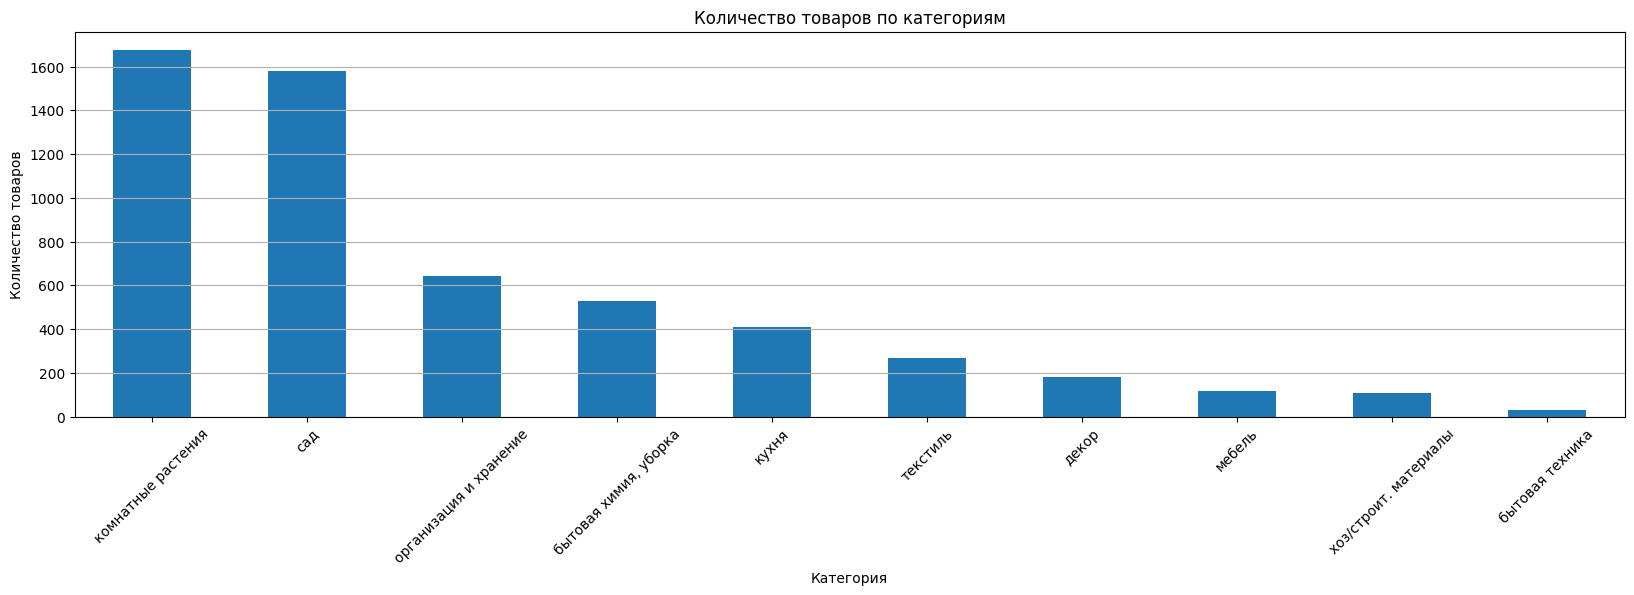

In [21]:
category_counts = df.groupby('category')['product'].count().sort_values(ascending=False)

plt.figure(figsize=(20,5))
category_counts.plot(kind='bar')
plt.xlabel('Категория')
plt.ylabel('Количество товаров')
plt.title('Количество товаров по категориям')
plt.grid(axis='y')  
plt.xticks(rotation=45) 
plt.show()

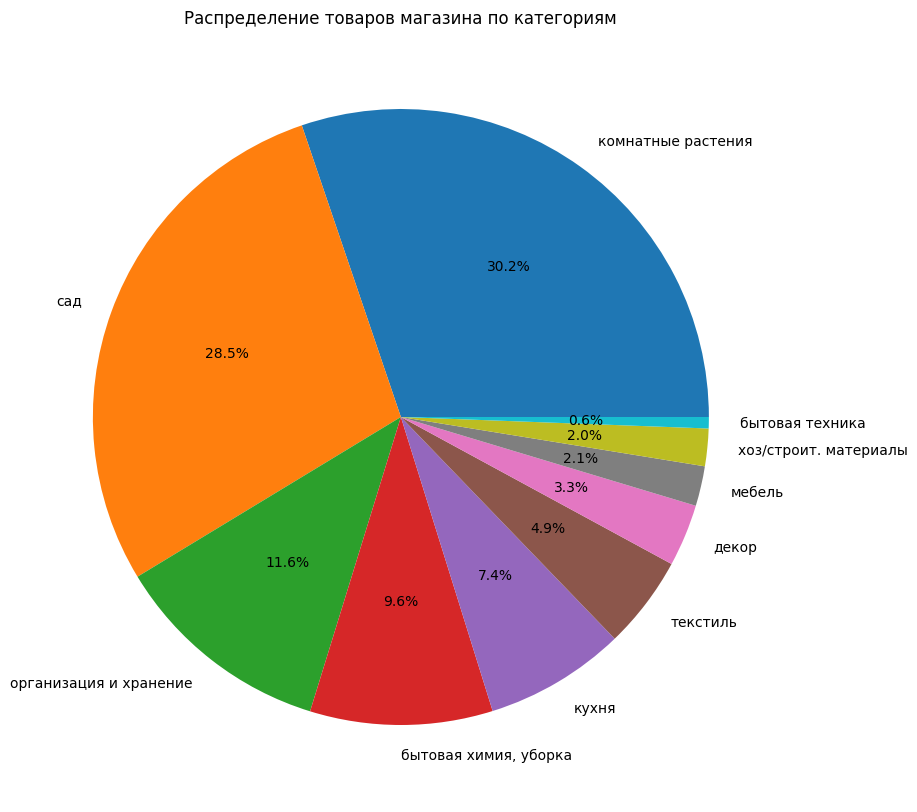

In [22]:
plt.figure(figsize=(10,10))
plt.pie(category_counts, 
        labels=category_counts.index, 
        autopct='%1.1f%%'  
              )  # палитра для разных категорий
plt.title('Распределение товаров магазина по категориям')
plt.show()

В магазине преобладает количество товаров в категориях "комнатные растения" и "сад"-30.2% и 28.5% всего ассортимента магазина. В категории "организация и хранение" представлено уже намного меньше позиций - порядка 11.6%. бытовая техника представлена в магазине в самом минимальном количестве позиций - 0.6%

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5544 entries, 0 to 5543
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         5544 non-null   datetime64[ns]
 1   customer_id  5544 non-null   object        
 2   order_id     5544 non-null   int64         
 3   product      5544 non-null   object        
 4   quantity     5544 non-null   int64         
 5   price        5544 non-null   float64       
 6   revenue      5544 non-null   float64       
 7   year_month   5544 non-null   object        
 8   category     5544 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 389.9+ KB


Проведена предобработка данных: данные обогащены, проверены на пропуски и дубликаты. 

## Исследовательский анализ данных

### Проверка на выбросы

Количественные параметры необходимо проверить на выбросы. 

array([[<AxesSubplot:title={'center':'order_id'}>,
        <AxesSubplot:title={'center':'revenue'}>]], dtype=object)

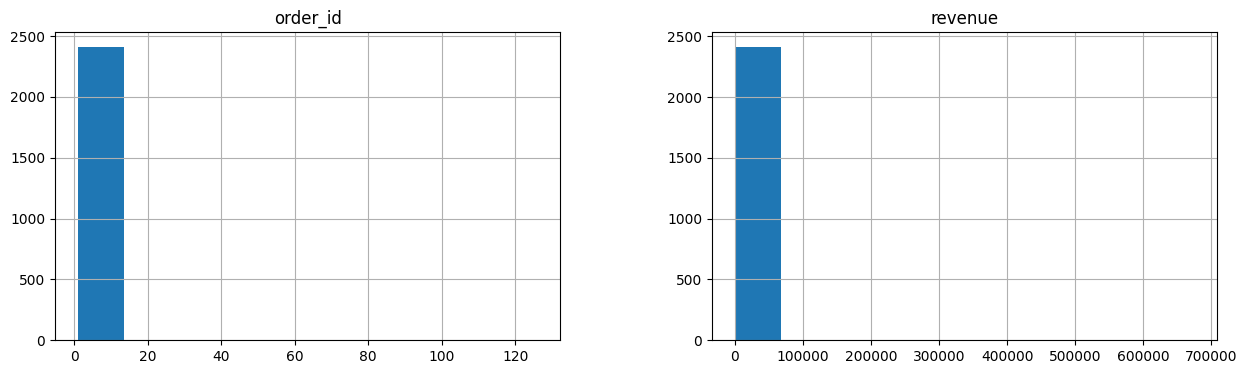

In [24]:
df_grouped=df.groupby('customer_id')[['order_id', 'revenue']].agg({
    'order_id': 'nunique',
    'revenue': 'sum'
})

#построение распределений количества заказов и выручки
df_grouped.hist(figsize=(15, 4))

При построении распределения видны немногочислыенные, но аномально большие выбросы в данных по количеству заказов на пользователя и выручки на пользователя.  Для корректной дальнейшей кластеризации покупателей необходимо аномальные значения удалить. 

Вывод топ 10 пользователей по количеству заказов.

In [25]:
top_customers=df.groupby('customer_id')['order_id'].nunique().reset_index().sort_values(by='order_id', ascending=False).head(10)
top_customers

,customer_id,order_id
1885,c971fb21-d54c-4134-938f-16b62ee86d3b,126
730,4d93d3f6-8b24-403b-a74b-f5173e40d7db,35
1080,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,17
1719,b7b865ab-0735-407f-8d0c-31f74d2806cc,7
17,0184f535-b60a-4914-a982-231e3f615206,5
1790,bea7a833-2074-42db-bc49-4457abd3c930,4
688,498f12a4-6a62-4725-8516-cf5dc9ab8a3a,4
2110,e0535076-6270-4df2-8621-cb06264a94fa,4
986,6a86cc77-ef15-496f-b5d3-89005597ee5d,3
789,552e17df-ba16-4e66-84fb-55a5557a6bea,3


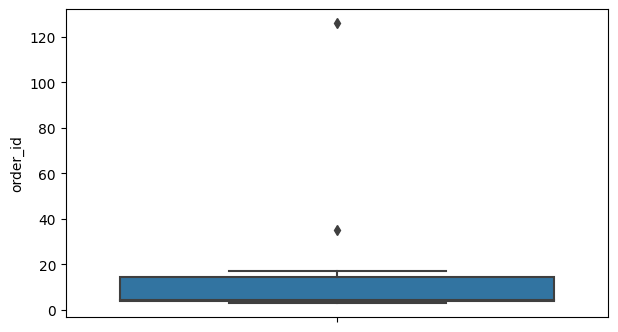

In [26]:
plt.figure(figsize=(7, 4))
sns.boxplot(y=top_customers['order_id'])
plt.show()

Очевидны аномальные пользователи со 126 и 35 заказами. Принято решение удалить

In [27]:
customers_outliers = top_customers.head(2)
df = df[df['customer_id'].isin(customers_outliers['customer_id']) == False]

Вывод топ 10 заказов по сумме заказа.

In [28]:
top_orders=df.groupby('order_id')['revenue'].sum().reset_index().sort_values(by='revenue', ascending=False)
top_orders

,order_id,revenue
1860,71743,675000.0
1823,71668,49432.0
938,69830,47385.0
645,69156,33680.0
802,69504,32718.0
...,...,...
3002,107790,10.0
2977,107324,10.0
3247,111690,10.0
2915,106536,10.0


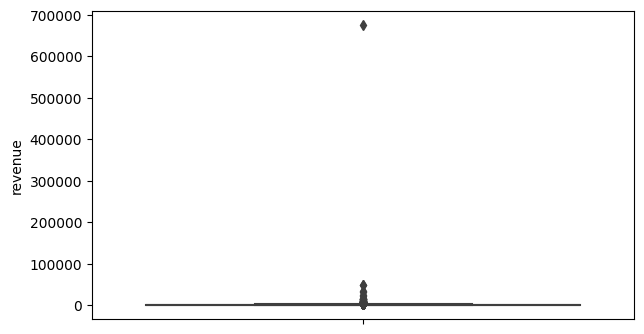

In [29]:
plt.figure(figsize=(7, 4))
sns.boxplot(y=top_orders['revenue'])
plt.show()

In [30]:
orders_outliers=top_orders.head(1)
order = df[df['order_id'].isin(orders_outliers['order_id'])]
order

,date,customer_id,order_id,product,quantity,price,revenue,year_month,category
3794,2019-06-18,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"Вантуз с деревянной ручкой d14 см красный, Burstenmann, 0522/0000",1000,675.0,675000.0,2019-06,"бытовая химия, уборка"


In [31]:
df = df[df['order_id'].isin(order['order_id']) == False]


Удалены аномальные значения из данных: заказ на 675000 на 100 вантузов.

### Среднее количество заказов

In [32]:
orders_per_customer = df.groupby('customer_id')['order_id'].nunique().sort_values(ascending=False)
orders_per_customer

customer_id
73d1cd35-5e5f-4629-8cf2-3fda829d4e58    17
b7b865ab-0735-407f-8d0c-31f74d2806cc     7
0184f535-b60a-4914-a982-231e3f615206     5
e0535076-6270-4df2-8621-cb06264a94fa     4
bea7a833-2074-42db-bc49-4457abd3c930     4
                                        ..
69cf691b-a6c2-4543-aa8a-8cf42fe4a76e     1
69c524f1-dd2a-4c4e-a5b0-def54dc96f9e     1
69b17a52-a59b-4656-8d47-375e81e7d5f1     1
69897438-1f6c-42f3-8876-ec7f0296072d     1
ffe82299-3f5b-4214-87fe-3d36ecccfac3     1
Name: order_id, Length: 2410, dtype: int64

In [33]:
display(f'Среднее количество заказов на покупателя: {orders_per_customer.mean():.2f}')
display(f'Медианное количество заказов на покупателя: {orders_per_customer.median()}')

'Среднее количество заказов на покупателя: 1.38'

'Медианное количество заказов на покупателя: 1.0'

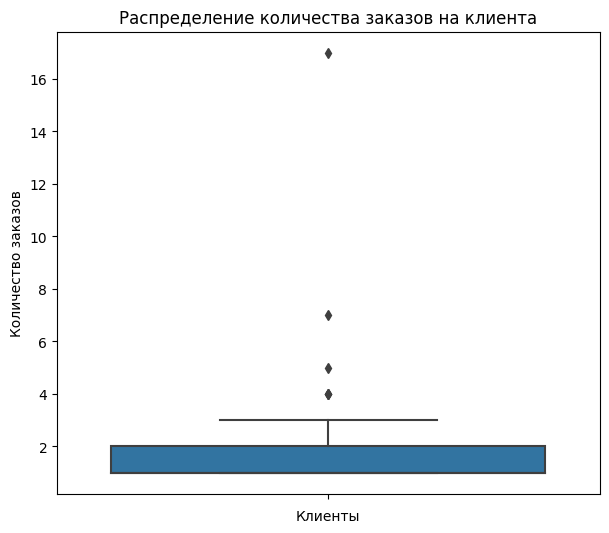

In [34]:
plt.figure(figsize=(7, 6)) 
sns.boxplot(y=orders_per_customer)
plt.title("Распределение количества заказов на клиента")  
plt.ylabel("Количество заказов")                              
plt.xlabel("Клиенты") 
plt.show()

**Большинство клиентов делают один заказ и больше не возвращаются.**

### Среднее количество позиций в заказе

In [35]:
products_per_order = df.groupby('order_id')['product'].count().sort_values(ascending=False)
products_per_order

order_id
14698     51
14715     36
14688     31
14753     30
14835     29
          ..
70721      1
70723      1
70725      1
70727      1
112789     1
Name: product, Length: 3330, dtype: int64

In [36]:
display(f'Среднее количество позиций на покупателя: {products_per_order.mean():.2f}')
display(f'Медианное количество позиций на покупателя: {products_per_order.median()}')

'Среднее количество позиций на покупателя: 1.61'

'Медианное количество позиций на покупателя: 1.0'

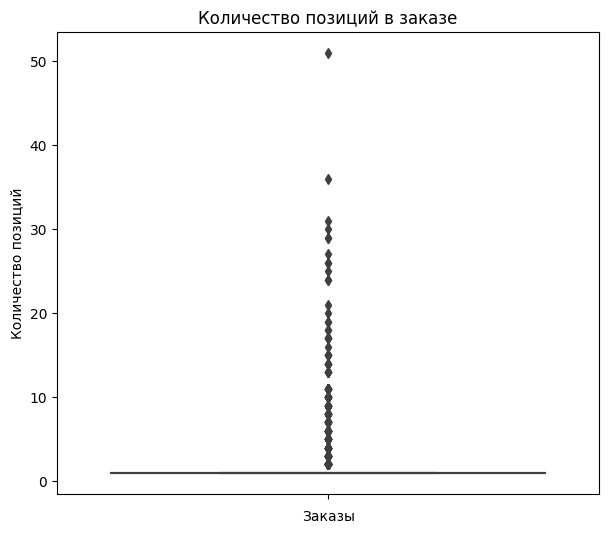

In [37]:
plt.figure(figsize=(7, 6)) 
sns.boxplot(y=products_per_order)
plt.title("Количество позиций в заказе")  
plt.ylabel("Количество позиций")                              
plt.xlabel("Заказы")
plt.show()

**Большинство заказов состоит только из одной позиции.**

### Средняя выручка на покупателя

In [38]:
total_per_customer = df.groupby('customer_id')['revenue'].sum().sort_values(ascending=False)
total_per_customer

customer_id
58a4c3cc-504f-43ea-a74a-bae19e665552    53232.0
146cd9bf-a95c-4afb-915b-5f6684b17444    49432.0
498f12a4-6a62-4725-8516-cf5dc9ab8a3a    41900.0
8fba3604-ef57-4b9f-b2fe-3402fa8825c8    33680.0
6987e6d6-a63a-4ce2-a2d0-f424092d235e    32718.0
                                         ...   
21df03ad-d9ac-47e9-a482-5372fd3e2464       22.0
10f79846-2640-4c43-8392-4e76ff5455ef       22.0
e9e94e71-4cd2-47fc-9b3f-1ec96bd2d95e       22.0
2330d859-e9cb-4c8f-abd0-55f9e27e6745       15.0
9777b839-4212-41bb-94c2-87de3658248a       15.0
Name: revenue, Length: 2410, dtype: float64

In [39]:
display(f'Средняя выручка на покупателя: {total_per_customer.mean():.2f}')
display(f'Медианная выручка на покупателя: {total_per_customer.median():.2f}')

'Средняя выручка на покупателя: 1539.21'

'Медианная выручка на покупателя: 838.00'

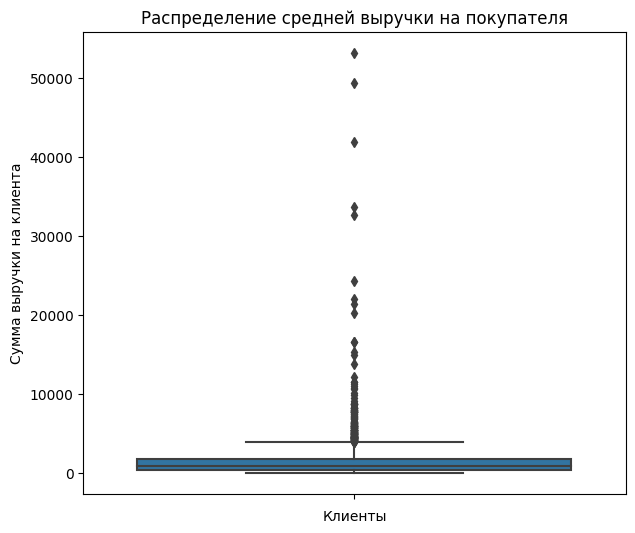

In [40]:
plt.figure(figsize=(7, 6)) 
sns.boxplot(y=total_per_customer)
plt.title("Распределение средней выручки на покупателя")  
plt.ylabel("Сумма выручки на клиента")                              
plt.xlabel("Клиенты") 
plt.show()

**Средняя выручка на покупателя - 1562, медианная выручка - 838.**

### Средний чек на клиента

In [41]:
# Сначала считаем сумму выручки по каждому заказу
order_per_customer = df.groupby(['customer_id', 'order_id'])['revenue'].sum().reset_index()

# Средний чек на клиента = среднее по всем заказам этого клиента
avg_check_per_customer = order_per_customer.groupby('customer_id')['revenue'].mean().sort_values(ascending=False)
avg_check_per_customer

customer_id
146cd9bf-a95c-4afb-915b-5f6684b17444    49432.0
8fba3604-ef57-4b9f-b2fe-3402fa8825c8    33680.0
6987e6d6-a63a-4ce2-a2d0-f424092d235e    32718.0
58a4c3cc-504f-43ea-a74a-bae19e665552    26616.0
1b2764ad-9151-4051-a46a-9b01b62e6335    24370.0
                                         ...   
e9e94e71-4cd2-47fc-9b3f-1ec96bd2d95e       22.0
f420bf6d-9985-47bc-95a7-5c640ad6d001       22.0
48788184-498b-49da-955e-7737bf7c9047       22.0
9777b839-4212-41bb-94c2-87de3658248a       15.0
2330d859-e9cb-4c8f-abd0-55f9e27e6745       15.0
Name: revenue, Length: 2410, dtype: float64

In [42]:
display(f"Средний чек на покупателя: {avg_check_per_customer.mean():.2f}")
display(f"Медианный чек на покупателя: {avg_check_per_customer.median():.2f}")

'Средний чек на покупателя: 1176.45'

'Медианный чек на покупателя: 652.00'

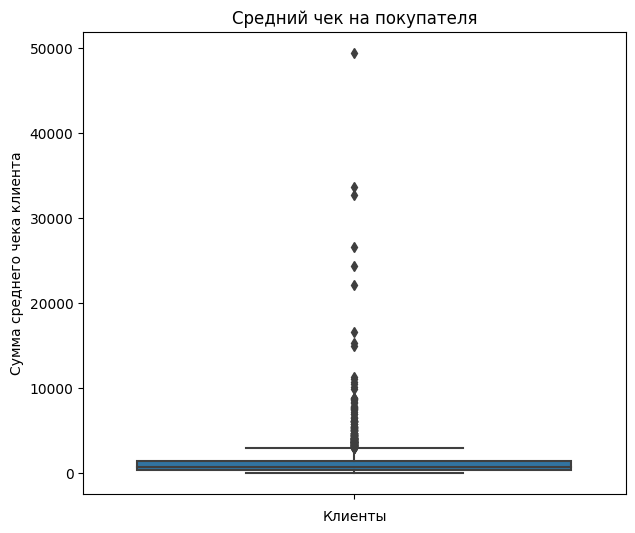

In [43]:
plt.figure(figsize=(7, 6)) 
sns.boxplot(y=avg_check_per_customer)
plt.title("Средний чек на покупателя")  
plt.ylabel("Сумма среднего чека клиента")                              
plt.xlabel("Клиенты") 
plt.show()

**Средний чек на покупателя - 1176, медианный - 652. Этот показатель сравнительно немного ниже показателя выручки, что говорит о небольшом объеме повторных покупок.** 

### Покупательская активность

In [44]:
revenue_per_season=df.groupby(['year_month'])['revenue'].sum().sort_values(ascending=False)
revenue_per_season

year_month
2018-11    334367.000000
2019-04    316469.000000
2018-12    302456.000000
2018-10    265645.000000
2019-02    260436.000000
2019-03    243507.000000
2019-05    238294.000000
2019-07    235410.000000
2019-06    228176.000000
2019-01    221528.000000
2019-10    207441.000000
2019-12    202885.333333
2019-09    177951.000000
2020-01    174036.333333
2019-08    172100.000000
2019-11    128791.750000
Name: revenue, dtype: float64

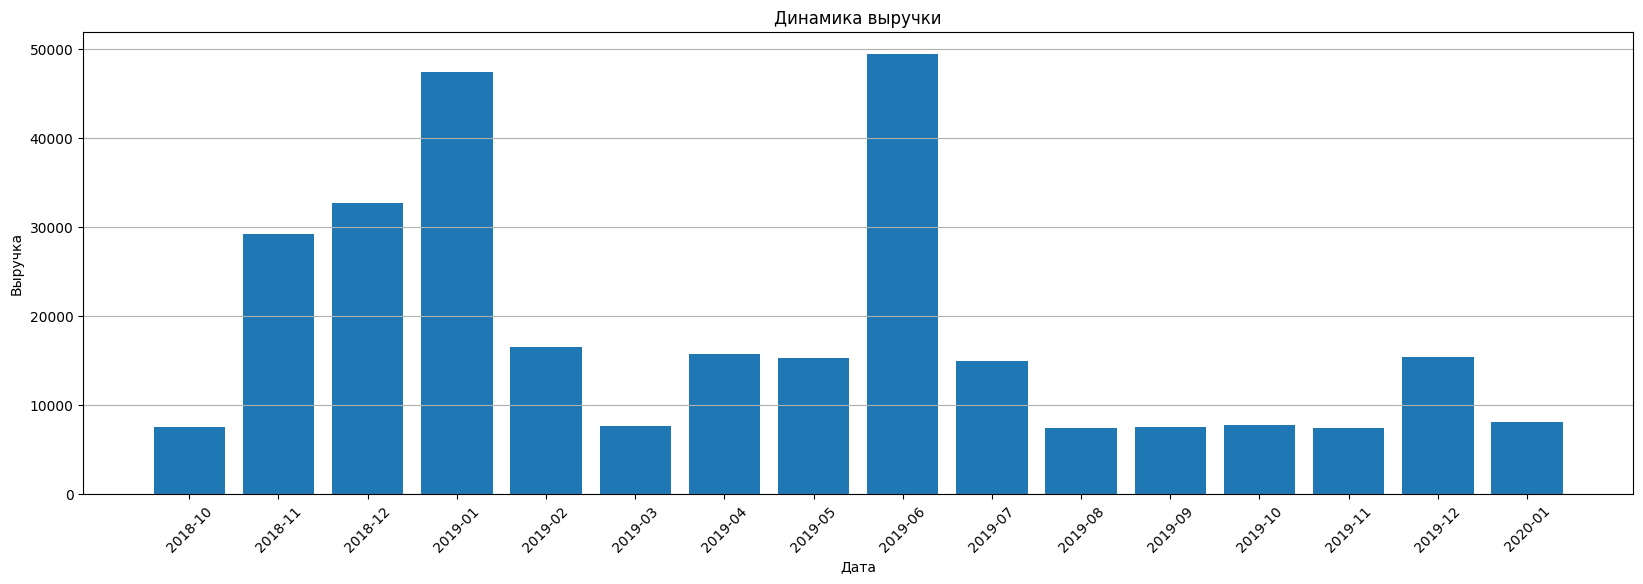

In [45]:
plt.figure(figsize=(20, 6))  
plt.bar(df['year_month'], df['revenue'])  
plt.xlabel('Дата')
plt.ylabel('Выручка')  
plt.title('Динамика выручки')
plt.grid(axis='y')  
plt.xticks(rotation=45)  
plt.show()

**Пики выручки приходятся на январь и июнь 2019.**

In [46]:
orders_cnt=df.groupby('year_month')['order_id'].nunique().reset_index().sort_values(by='order_id', ascending=False)
orders_cnt

,year_month,order_id
15,2020-01,269
6,2019-04,264
4,2019-02,259
14,2019-12,246
2,2018-12,235
5,2019-03,235
13,2019-11,217
12,2019-10,201
9,2019-07,198
1,2018-11,184


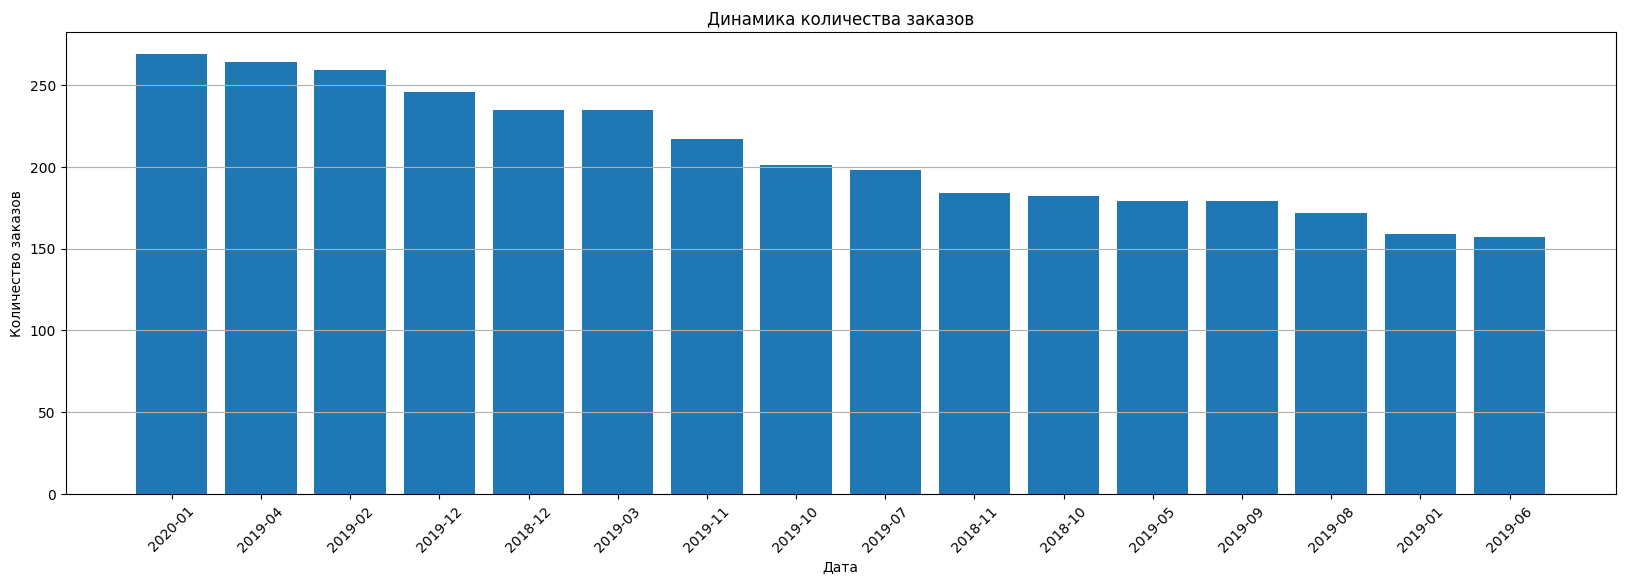

In [47]:
plt.figure(figsize=(20, 6)) 

plt.bar(orders_cnt['year_month'], orders_cnt['order_id'])  
plt.xlabel('Дата')
plt.ylabel('Количество заказов')  
plt.title('Динамика количества заказов')
plt.grid(axis='y')  
plt.xticks(rotation=45)  
plt.show()

**Количество заказов от месяца к месяцу только уменьшается.**

### Категории товаров

In [48]:
rev_per_category=df.groupby(['category'])['order_id'].nunique().sort_values(ascending=False).round(2)
rev_per_category

category
комнатные растения        803
сад                       773
организация и хранение    547
бытовая химия, уборка     468
кухня                     341
текстиль                  241
декор                     127
мебель                    109
хоз/строит. материалы      97
бытовая техника            32
Name: order_id, dtype: int64

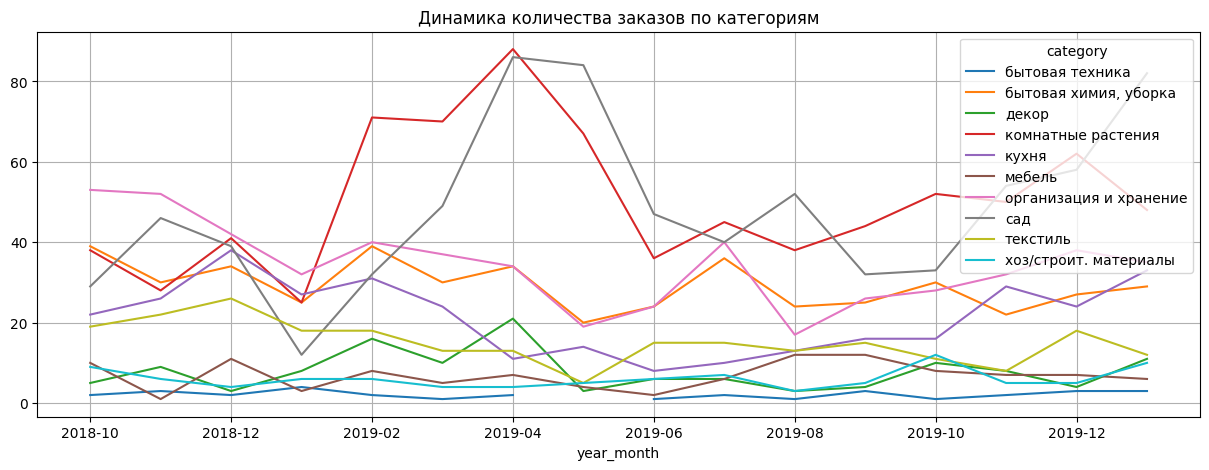

In [49]:
df.pivot_table(
    index='year_month',
    columns = 'category',
    values = 'order_id',
    aggfunc = 'nunique'
).plot(figsize=(15,5), grid=True)
plt.title(f'Динамика количества заказов по категориям')
plt.show()

**Как раз в весенние месяцы виден пик количества заказов в категории "сад" и на втором месте "комнатные растения".**

## Кластеризация покупателей 

### Подготовка данных с параметрами

In [50]:
#подсчет суммы заказа и количества позиций в заказе и цену товара
orders_per_customer = df.groupby(['customer_id', 'order_id']).agg({
    'revenue': 'sum',
    'quantity': 'sum'
    }).reset_index()

#подсчет средней цены товара в заказе
orders_per_customer['avg_price'] = orders_per_customer['revenue'] / orders_per_customer['quantity']


In [51]:
#подсчет среднего чека на покупателя, среднего количества позиций в заказе, количества заказов
customers_parameters=orders_per_customer.groupby('customer_id').agg(
      avg_check=('revenue', 'mean'),
      avg_items=('quantity', 'mean'),
      avg_price=('avg_price', 'mean'),
      total_orders=('order_id', 'nunique')
      
).reset_index()

customers_parameters.sort_values(by='total_orders', ascending=False)

,customer_id,avg_check,avg_items,avg_price,total_orders
1078,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,1256.529412,1.000000,1256.529412,17
1717,b7b865ab-0735-407f-8d0c-31f74d2806cc,539.857143,9.714286,99.238095,7
17,0184f535-b60a-4914-a982-231e3f615206,1178.200000,11.600000,171.090753,5
2107,e0535076-6270-4df2-8621-cb06264a94fa,159.000000,1.000000,159.000000,4
1788,bea7a833-2074-42db-bc49-4457abd3c930,1102.250000,7.500000,142.928571,4
...,...,...,...,...,...
975,69cf691b-a6c2-4543-aa8a-8cf42fe4a76e,3525.000000,15.000000,235.000000,1
974,69c524f1-dd2a-4c4e-a5b0-def54dc96f9e,149.000000,1.000000,149.000000,1
973,69b17a52-a59b-4656-8d47-375e81e7d5f1,1574.000000,1.000000,1574.000000,1
972,69897438-1f6c-42f3-8876-ec7f0296072d,1799.000000,1.000000,1799.000000,1


**Подготовлен датасет с параметрами для дальнейшей кластеризации. Алгоритму машинного обучения будут переданы параметры: Средний чек на покупателя, среднее количество позиций в заказе на покупателя, средняя цена за единицу товара на покупателя, количество заказов на покупателя.**

### Кластеризация

In [52]:
data_st=customers_parameters.drop(['customer_id'], axis=1)
scaler = StandardScaler()
data_st= scaler.fit_transform(data_st)


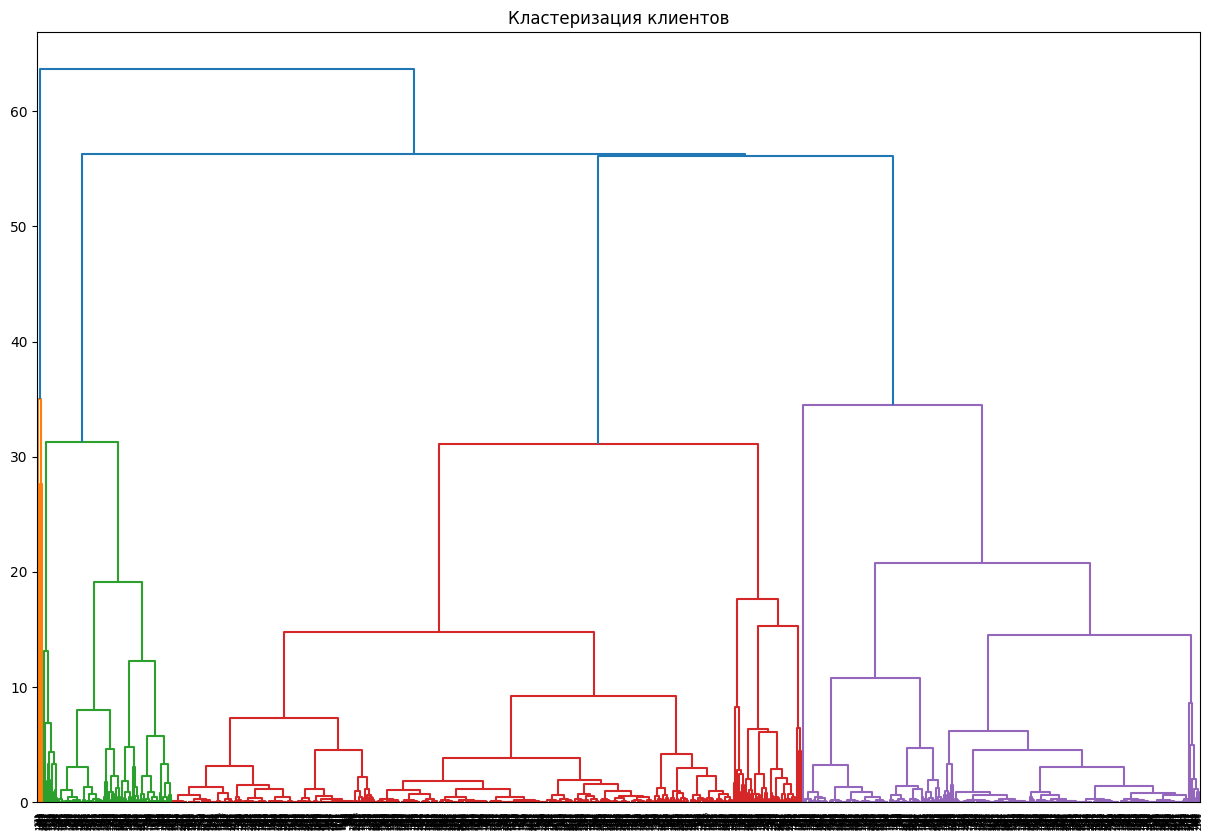

In [53]:
linked = linkage(data_st, method = 'ward') 
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Кластеризация клиентов')
plt.show() 

**На выведенной дендрограмме видно 4 кластера покупателей.**

In [54]:
km = KMeans(n_clusters=4, random_state=0)
labels = km.fit_predict(data_st)
customers_parameters['cluster'] = labels
clusters = customers_parameters.groupby(['cluster']).mean()
display(clusters)

,avg_check,avg_items,avg_price,total_orders
cluster,,,,
0,914.353296,5.362155,422.818713,1.000000
1,698.483615,1.607354,618.609671,2.057953
2,4543.036778,2.334264,3473.616699,1.346369
3,18378.888889,194.666667,143.773927,1.000000


In [55]:
customers_parameters.head()

,customer_id,avg_check,avg_items,avg_price,total_orders,cluster
0,000d6849-084e-4d9f-ac03-37174eaf60c4,555.0,4.0,138.75,1,0
1,001cee7f-0b29-4716-b202-0042213ab038,442.0,1.0,442.00,1,0
2,00299f34-5385-4d13-9aea-c80b81658e1b,914.0,2.0,457.00,1,0
3,002d4d3a-4a59-406b-86ec-c3314357e498,1649.0,1.0,1649.00,1,0
4,003bbd39-0000-41ff-b7f9-2ddaec152037,2324.0,2.0,1162.00,1,0


**Машинным обучением, методом K-Means покупатели были разделены на 4 кластера. Далее будет приведено описание каждого кластера.**

**Кластер 0**

- Клиенты с небольшим средним чеком — около 914
- В заказе в среднем около 5 позиций
- Средняя цена за единицу товара — 423
- Обычно оформляют только один заказ
- Составляют большинство — примерно 57% покупателей

**Кластер 1**

- Клиенты с самым низким средним чеком — около 698
- Минимальное количество позиций в заказе — 1
- Достаточно высокая средняя цена за единицу товара — 619
- В среднем делают 2 заказа
- Доля — около 36% покупателей

**Кластер 2**

- Клиенты с высоким средним чеком — около 4543
- В заказе в среднем около 2 позиций
- Самая высокая средняя цена за единицу товара — 3474
- Обычно делают только один заказ
- Таких покупателей немного — около 5.2%

**Кластер 3**

- Клиенты с максимально высоким средним чеком — около 18 379
- Очень большое количество позиций в заказе — в среднем 194
- Самая низкая средняя цена за единицу товара — 144
- Делают только один заказ
- Составляют лишь 0.3% клиентов



### Проверка стат.значимости

#### по среднему чеку:

Проверяем статистическим тестом наличие статистической значимости между кластерами по параметру среднего чека:

 - H0 - статистически значимой разницы между средний чеком кластеров клиентов нет
 - H1 - статистически значимая разница между средний чеком кластеров клиентов есть

Выбран непараметрический тест  Манна-Уитни 

In [56]:
clusters = customers_parameters['cluster'].unique()  

pairs = list(combinations(clusters, 2))

print(pairs)

[(0, 2), (0, 1), (0, 3), (2, 1), (2, 3), (1, 3)]


In [57]:
alpha=0.05
alpha_bonf=alpha/len(pairs)
alpha_bonf

0.008333333333333333

In [58]:

for c1, c2 in pairs:
    data1 = customers_parameters[customers_parameters['cluster'] == c1]['avg_check']
    data2 = customers_parameters[customers_parameters['cluster'] == c2]['avg_check']
    
    p = st.mannwhitneyu(data1, data2).pvalue
    
    print(f'Кластеры {c1} и {c2}: p-value = {p:.6f}.', 
          'Нулевая гипотеза отвергнута: разница статистически значима' if p < alpha_bonf 
          else 'Не получилось отвергнуть нулевую гипотезу, различие статистически не подтверждено')

Кластеры 0 и 2: p-value = 0.000000. Нулевая гипотеза отвергнута: разница статистически значима
Кластеры 0 и 1: p-value = 0.000025. Нулевая гипотеза отвергнута: разница статистически значима
Кластеры 0 и 3: p-value = 0.000000. Нулевая гипотеза отвергнута: разница статистически значима
Кластеры 2 и 1: p-value = 0.000000. Нулевая гипотеза отвергнута: разница статистически значима
Кластеры 2 и 3: p-value = 0.000113. Нулевая гипотеза отвергнута: разница статистически значима
Кластеры 1 и 3: p-value = 0.000000. Нулевая гипотеза отвергнута: разница статистически значима


#### по средней цене за единицу товара

Проверяем статистическим тестом наличие статистической значимости между кластерами по параметру средней цены за единицу товара:

H0 - статистически значимой разницы между средней ценой за единицу товара кластеров клиентов нет
H1 - статистически значимая разница между средней ценой за единицу товара кластеров клиентов есть
Выбран непараметрический тест Манна-Уитни

In [59]:

for c1, c2 in pairs:
    data1 = customers_parameters[customers_parameters['cluster'] == c1]['avg_price']
    data2 = customers_parameters[customers_parameters['cluster'] == c2]['avg_price']
    
    p = st.mannwhitneyu(data1, data2).pvalue
    
    print(f'Кластеры {c1} и {c2}: p-value = {p:.6f}.', 
          'Нулевая гипотеза отвергнута: разница статистически значима' if p < alpha_bonf  
          else 'Не получилось отвергнуть нулевую гипотезу, различие статистически не подтверждено')

Кластеры 0 и 2: p-value = 0.000000. Нулевая гипотеза отвергнута: разница статистически значима
Кластеры 0 и 1: p-value = 0.000000. Нулевая гипотеза отвергнута: разница статистически значима
Кластеры 0 и 3: p-value = 0.007339. Нулевая гипотеза отвергнута: разница статистически значима
Кластеры 2 и 1: p-value = 0.000000. Нулевая гипотеза отвергнута: разница статистически значима
Кластеры 2 и 3: p-value = 0.000001. Нулевая гипотеза отвергнута: разница статистически значима
Кластеры 1 и 3: p-value = 0.000188. Нулевая гипотеза отвергнута: разница статистически значима


**После проведения статистического теста кластеризация клиентов признана успешной и статистически значимой.**

### Анализ кластеров

In [60]:
data_claster=df.merge(customers_parameters, on='customer_id', how='left')


In [61]:
cluster_rate = data_claster.groupby('cluster')['customer_id'].count().reset_index()
cluster_rate['%'] = cluster_rate['customer_id'] / cluster_rate['customer_id'].sum() * 100 
cluster_rate

,cluster,customer_id,%
0,0,3051,56.974790
1,1,2012,37.572362
2,2,277,5.172736
3,3,15,0.280112


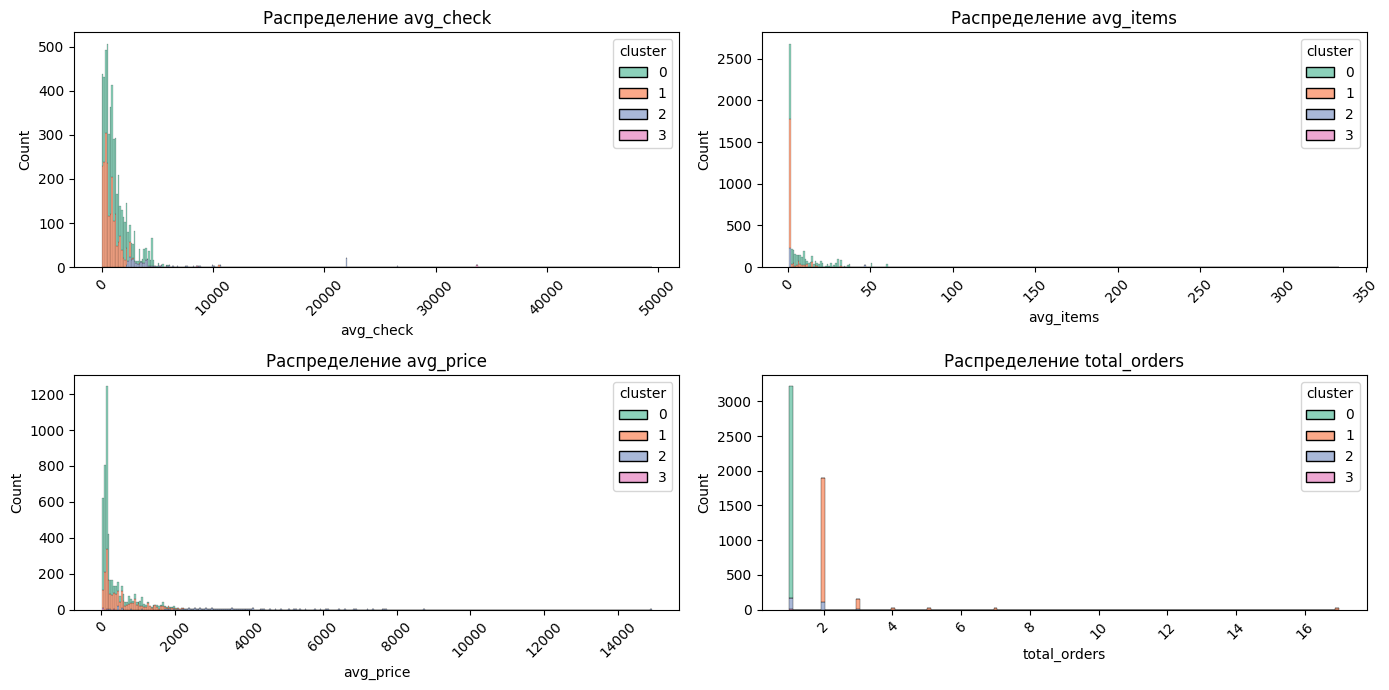

In [62]:
columns = ['avg_check', 'avg_items', 'avg_price', 'total_orders']

fig, axes = plt.subplots(2, 2, figsize=(14, 7))

for i, col in enumerate(columns):
    ax = axes[i//2, i%2]  
    sns.histplot(data=data_claster, x=col, hue='cluster', multiple='stack', palette='Set2', ax=ax)
    ax.set_title(f'Распределение {col}', fontsize=12, ha='center')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [63]:
#доля заказов по кластерам
cluster_orders_rate = data_claster.groupby('cluster')['order_id'].nunique().reset_index()
cluster_orders_rate['%'] = cluster_orders_rate['order_id'] / cluster_orders_rate['order_id'].sum() * 100 
cluster_orders_rate

,cluster,order_id,%
0,0,1411,42.372372
1,1,1669,50.120120
2,2,241,7.237237
3,3,9,0.270270


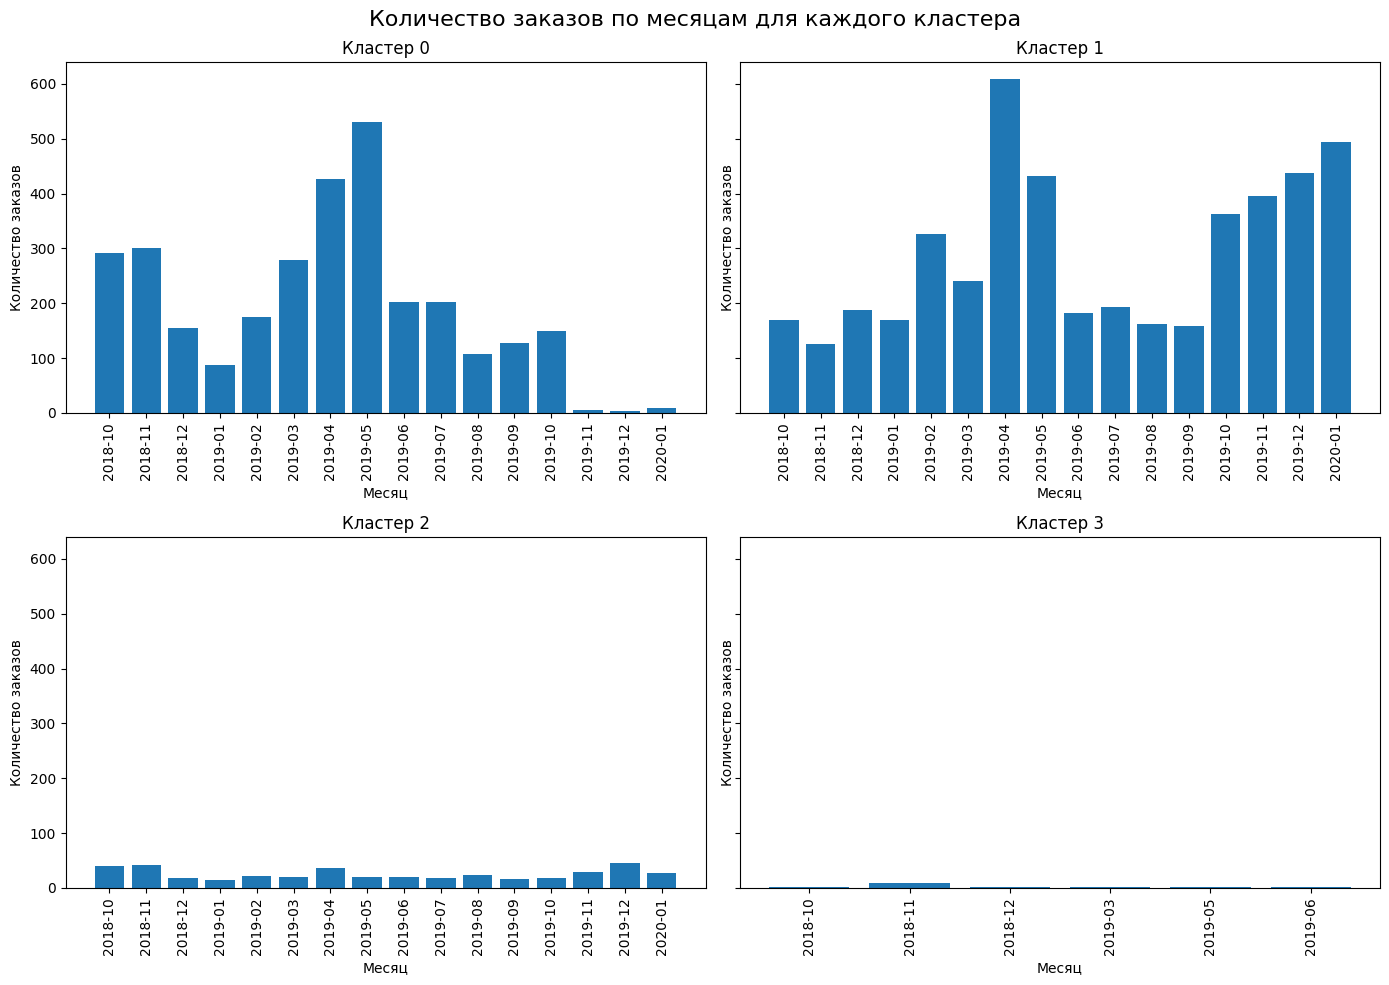

In [64]:
cluster_season = data_claster.groupby(['cluster', 'year_month'])['total_orders'].sum().reset_index()

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)



for i, ax in enumerate(axes.flatten()):
    cluster_data = cluster_season[cluster_season['cluster'] == i]
    ax.bar(cluster_data['year_month'], cluster_data['total_orders'])
    ax.set_title(f'Кластер {i}')
    ax.set_xlabel('Месяц')
    ax.set_ylabel('Количество заказов')
    ax.tick_params(axis='x', rotation=90)

fig.suptitle('Количество заказов по месяцам для каждого кластера', fontsize=16)
plt.tight_layout()
plt.show()

In [65]:
#доля выручки по кластерам
cluster_revenue_rate = data_claster.groupby('cluster')['revenue'].sum().reset_index()
cluster_revenue_rate['%'] = cluster_revenue_rate['revenue'] / cluster_revenue_rate['revenue'].sum() * 100 
cluster_revenue_rate

,cluster,revenue,%
0,0,1.290152e+06,34.779749
1,1,1.192940e+06,32.159119
2,2,1.060990e+06,28.602032
3,3,1.654100e+05,4.459099


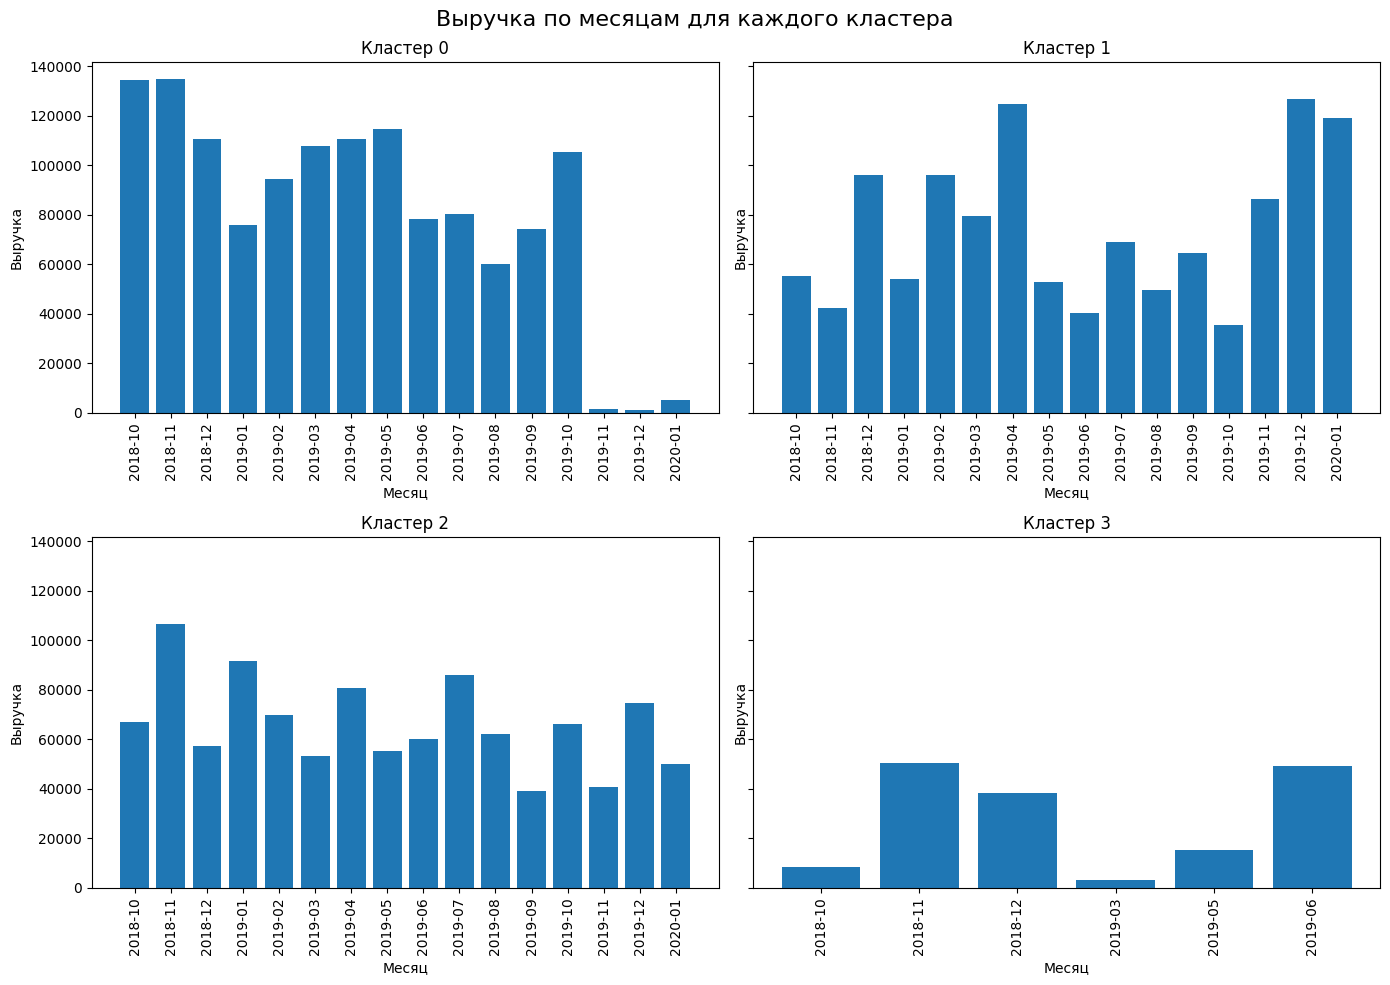

In [66]:
cluster_season = data_claster.groupby(['cluster', 'year_month'])['revenue'].sum().reset_index()

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)



for i, ax in enumerate(axes.flatten()):
    cluster_data = cluster_season[cluster_season['cluster'] == i]
    ax.bar(cluster_data['year_month'], cluster_data['revenue'])
    ax.set_title(f'Кластер {i}')
    ax.set_xlabel('Месяц')
    ax.set_ylabel('Выручка')
    ax.tick_params(axis='x', rotation=90)

fig.suptitle('Выручка по месяцам для каждого кластера', fontsize=16)
plt.tight_layout()
plt.show()

**Кластер 0**


- Составляют большинство — примерно 57% покупателей
- Сделали 42% всех заказов
- Пик заказов приходится на май 2019, в последние три месяца кол-во заказов минимально.
- Сделали 35% всей выручки

**Кластер 1**


- Доля — около 36% покупателей
- Сделали 50% всех заказов
- Пик заказов приходится на май 2019, в последние три месяца кол-во заказов резко выросло.
- Сделали 32% всей выручки

**Кластер 2**


- Таких покупателей немного — около 5.2%
- Сделали 7% всех заказов
- Минимальное количество заказов во все периоды, незначительный пик в апреле и декабре 2019
- Сделали 29% всей выручки

**Кластер 3**


- Составляют лишь 0.3% клиентов
- Сделали 0.3% всех заказов
- незначительное количество заказов не во все месяцы.
- Сделали 5% всей выручки

### Категории товаров

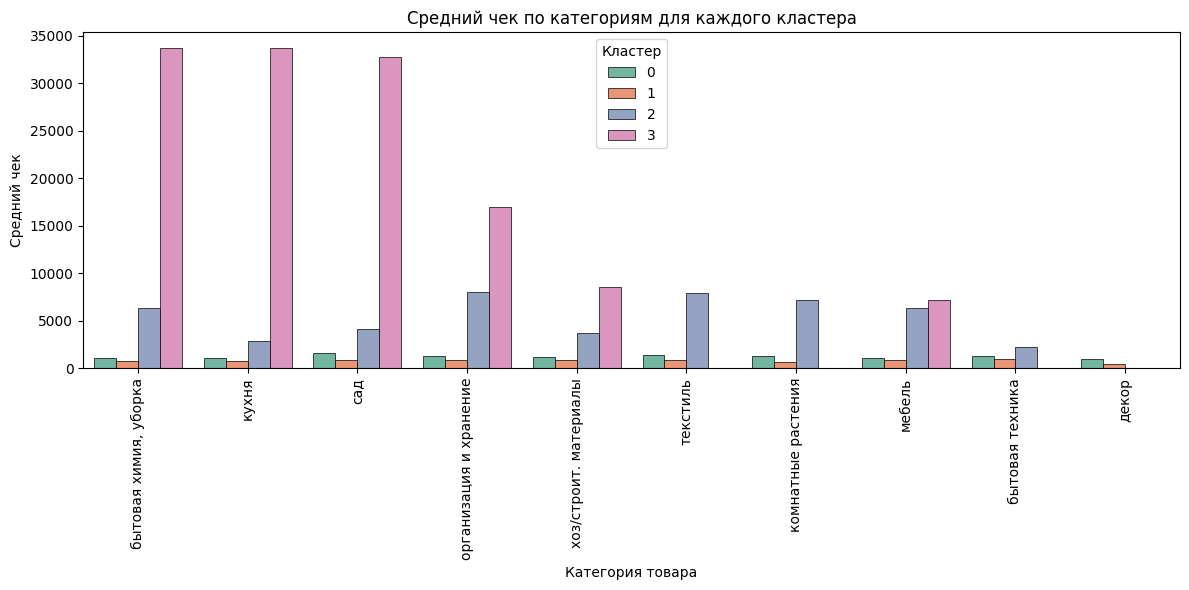

In [67]:
cluster_category = data_claster.groupby(['cluster', 'category'])['avg_check'].mean()\
                   .reset_index().sort_values(by='avg_check', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=cluster_category, 
    x='category', 
    y='avg_check', 
    hue='cluster',
    palette='Set2',
    edgecolor='black',    
    linewidth=0.5
)

plt.title('Средний чек по категориям для каждого кластера')
plt.xlabel('Категория товара')
plt.ylabel('Средний чек')
plt.xticks(rotation=90)
plt.legend(title='Кластер')
plt.tight_layout()
plt.show()

**Кластер 0:**

- Небольшой средний чек почти всем категориям, примерно до 2000


**Кластер 1:**

- Самый низкий средний чек по всем категориям, примерно до 1000
- В целом разница между категориями несущественная.


**Кластер 2:**
- Выделяются высокими средними чеками на текстиль, комнатные растения, мебель и бытовую технику, орг. и хранение - до 10000
- В других категориях (кухня, сад) тоже тратят заметно больше, чем кластеры 0 и 1.


**Кластер 3:**
- Лидер по средним чекам в категориях бытовая химия и уборка, кухня, сад, организация и хранение, хозтовары/стройматериалы-до 35000
- В этих категориях чеки достигают 30–35 тыс., что многократно выше других кластеров.




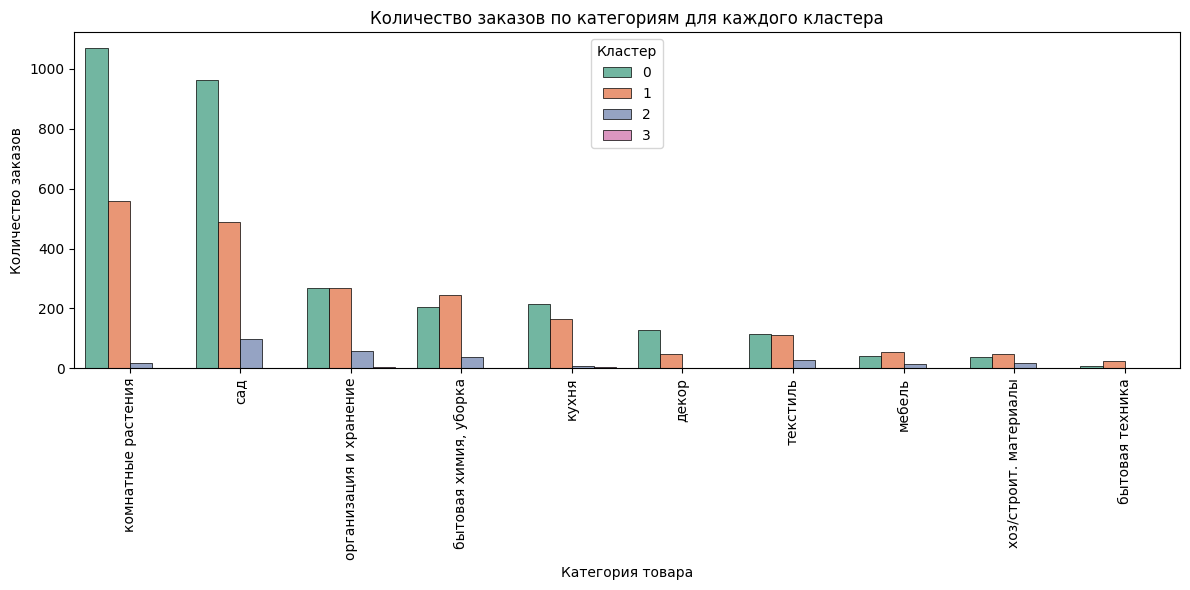

In [68]:
cluster_category = data_claster.groupby(['cluster', 'category'])['order_id'].count()\
                   .reset_index().sort_values(by='order_id', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=cluster_category, 
    x='category', 
    y='order_id', 
    hue='cluster',
    palette='Set2',
    edgecolor='black',    
    linewidth=0.5
)

plt.title('Количество заказов по категориям для каждого кластера')
plt.xlabel('Категория товара')
plt.ylabel('Количество заказов')
plt.xticks(rotation=90)
plt.legend(title='Кластер')
plt.tight_layout()
plt.show()

**Кластер 0:**
- Самое большое количество заказов в категориях комнатные растения и сад - чуть выше 1000


**Кластер 1:**
- В категориях комнатные растения и сад имеют самый высокое количество заказов своего кластера - до 600 заказов


**Кластер 2:**
- Небольшое количество заказов по всем категориям, больше всего заказов в категории сад и орг.и хранение - примерно до 100 заказов


**Кластер 3:**
- Минимальное количество заказов в некоторых категориях: кухня, мебель, быт.техника, орг и хранение.




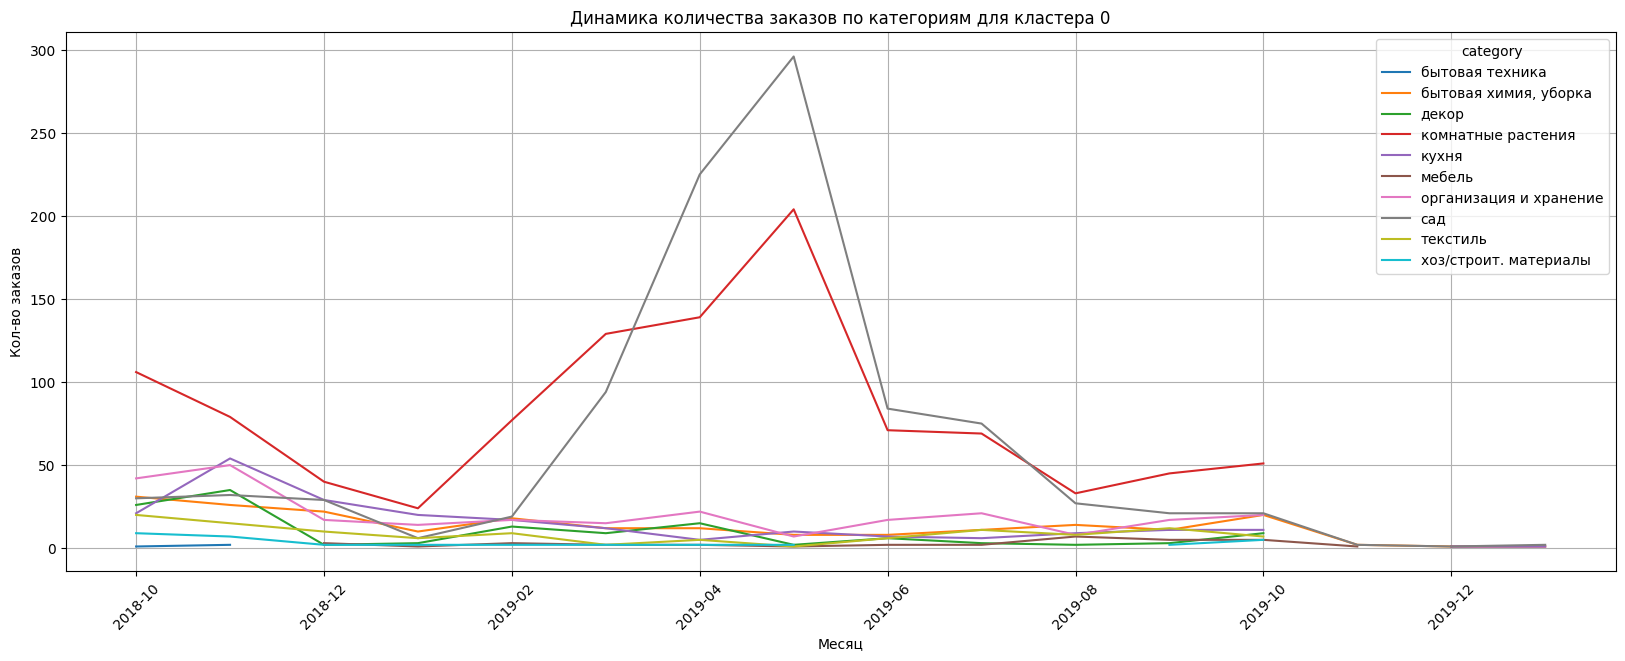

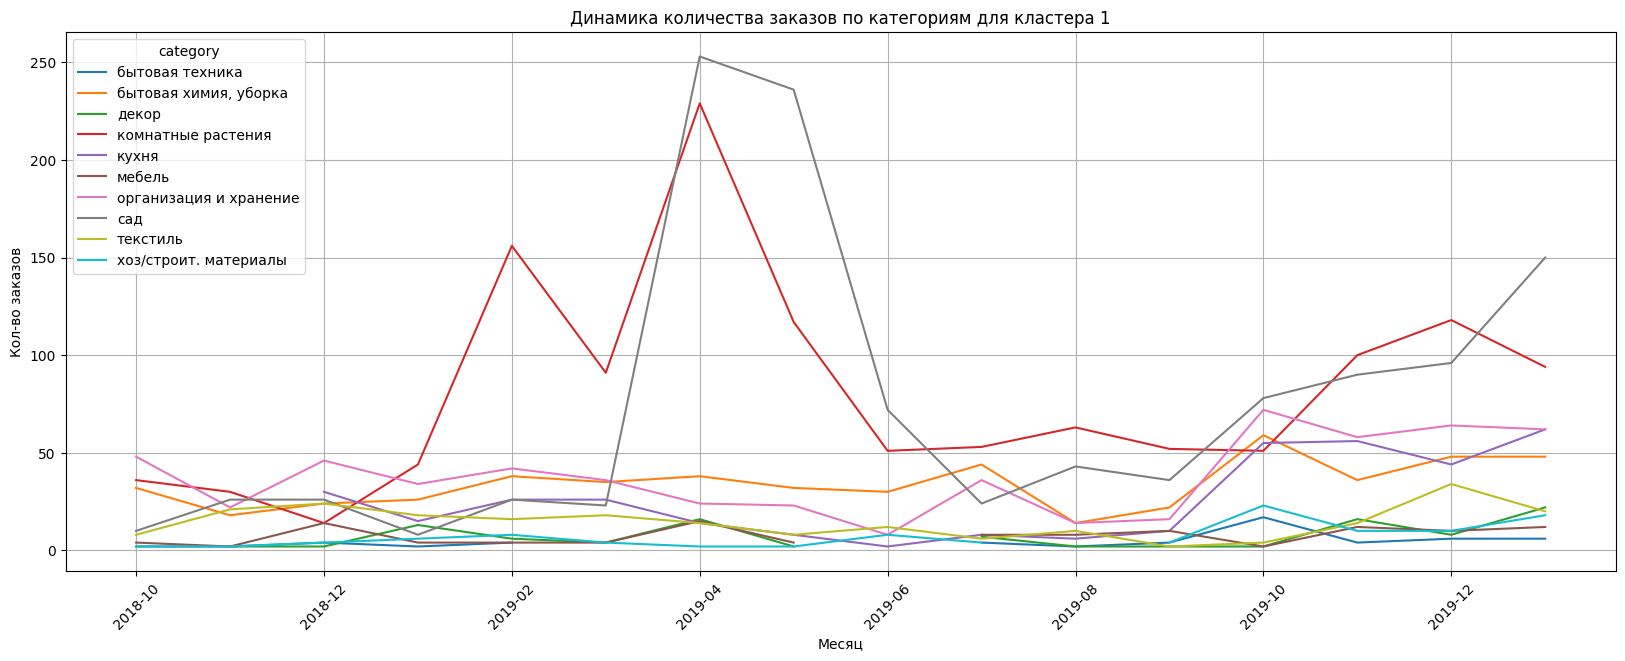

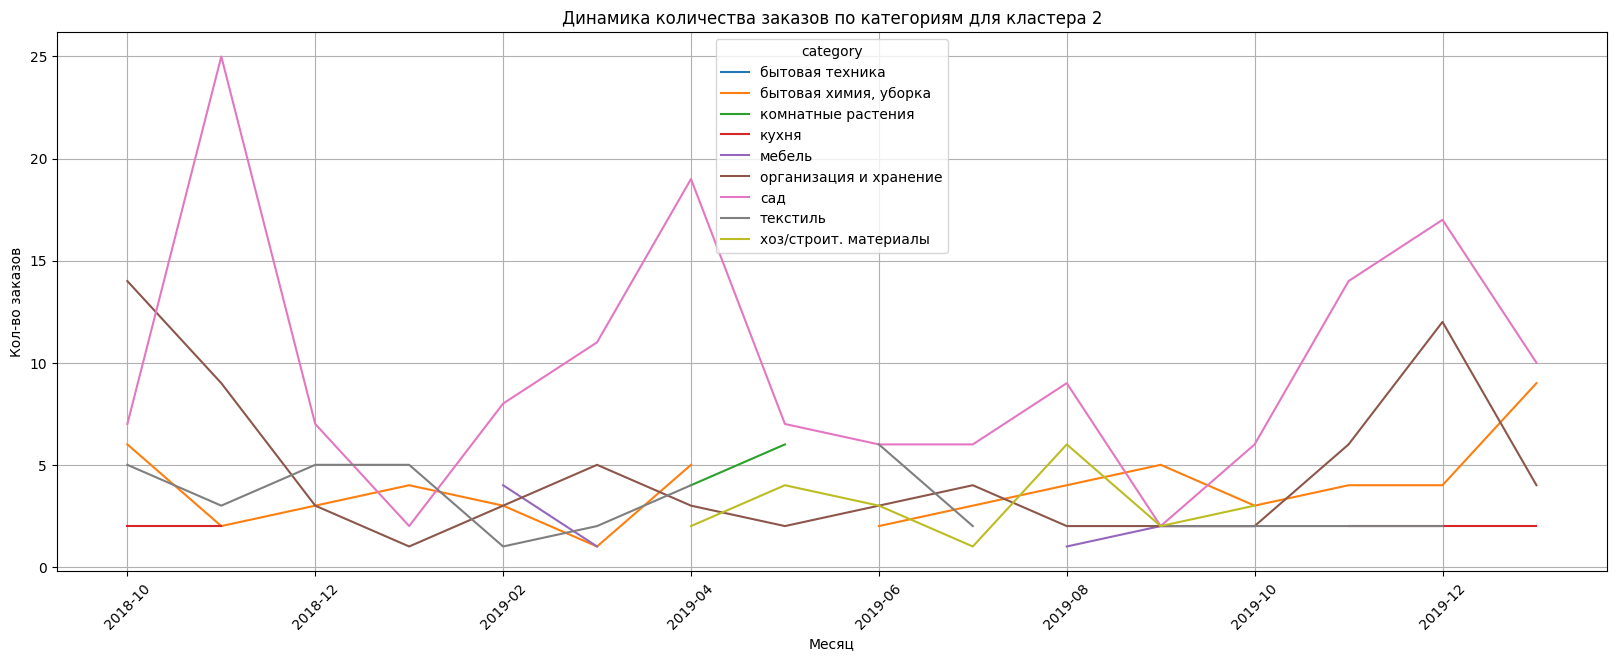

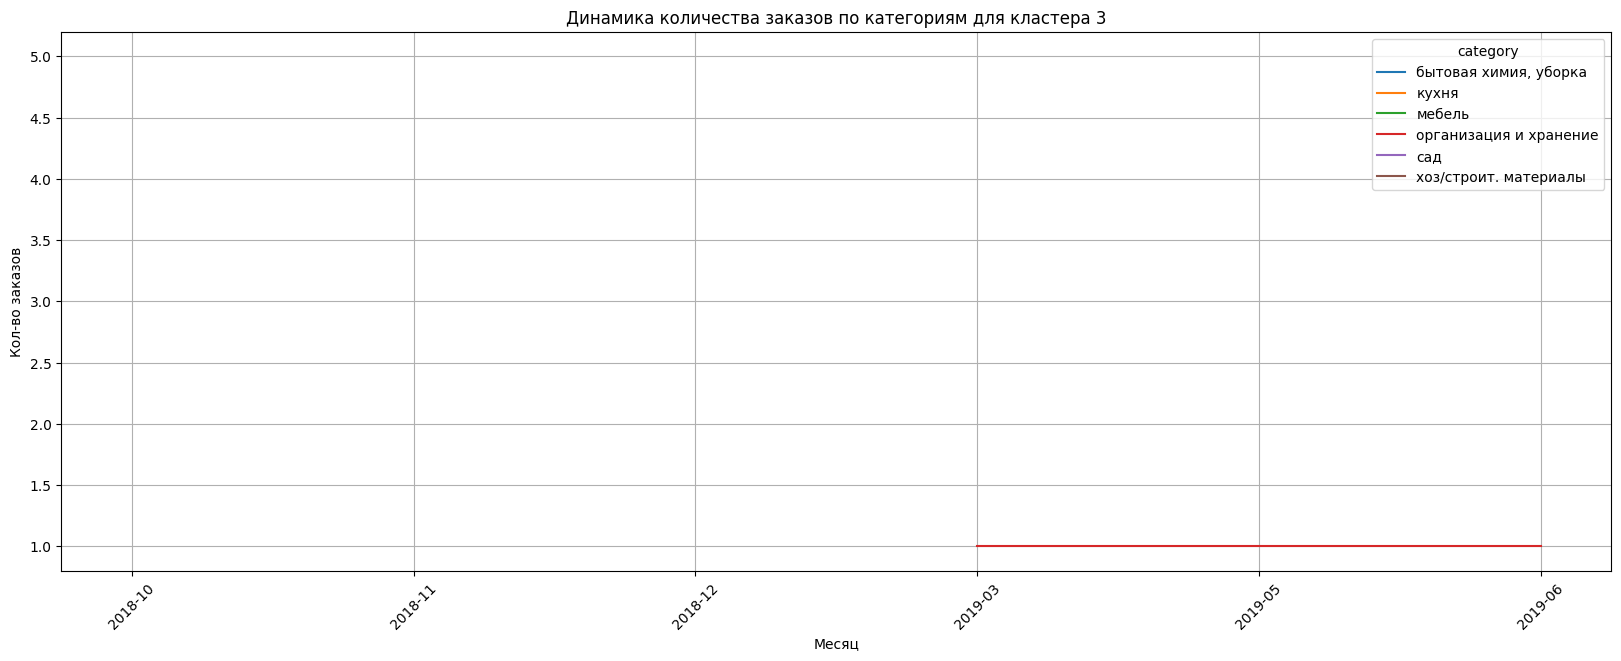

In [69]:
clusters = sorted(data_claster['cluster'].unique())

for cluster in clusters:
    pivot_cluster = (data_claster[data_claster['cluster'] == cluster]
                     .pivot_table(index='year_month',
                                  columns='category',
                                  values='total_orders',
                                  aggfunc='sum'))
    
    pivot_cluster.plot(figsize=(20, 7), grid=True, title=f'Кластер {cluster}')
    
    
    plt.xlabel("Месяц")
    plt.ylabel("Кол-во заказов")
    plt.xticks(rotation=45)
    plt.title(f'Динамика количества заказов по категориям для кластера {cluster}')
    plt.show()

**Кластер 0:**
- Пик заказов приходится на май 2019 в категориях сад, комнатные растения



**Кластер 1:**
- Пика заказов приходится на апрель-май 2019 в категориях сад, комнатные растения


**Кластер 2:**
- Пик заказов приходится на апрель 2019. Также был пик в в ноябре 2018 и в декабре 2019, также в категории сад.


**Кластер 3:**
- Динамики количества заказов не наблюдается.




## Вывод и рекоммендации

В результате проведенного исследования покупатели разделились на:

**Кластер 0 — «Массовые экономные» (57% клиентов, 42% заказов, 35% выручки):**

 - Низкий средний чек (914), 5 товаров в заказе, дешёвые покупки (423 за единицу).
 - Делают 1 заказ, пик — май 2019, сейчас активность минимальна.
 - Основные категории: сад и комнатные растения.
 - Рекомендации: сезонные предложения (сад/растения), стимулирование повторных заказов 

**Кластер 1 — «Регулярные бюджетные» (36% клиентов, 50% заказов, 32% выручки):**

 - Самый низкий средний чек (698), но выше средняя цена товара (619).
 - В среднем 2 заказа
 - Категории: сад и комнатные растения.
 - Рекомендации: сезонные предложения (сад/растения)

**Кластер 2 — «Дом и интерьер» (5% клиентов, 7% заказов, 29% выручки):**

 - Высокий средний чек (4543), дорогие товары (3474 за единицу), но всего 1 заказ.
 - Покупают текстиль, мебель, бытовую технику, организацию хранения.
 - Пики — апрель и декабрь.
 - Рекомендации: спец.предложения на повторный заказ, предложение дополнительных товаров-аксессуров к основной покупке, VIP-программы

**Кластер 3 — «Оптовые/премиальные» (0.3% клиентов, 0.3% заказов, 5% выручки):**

 - Очень высокий средний чек (18 379), огромные корзины (194 товаров), дешёвые позиции (144).
 - Делают единичные массовые закупки.
 - Категории: бытовая химия, хозтовары, сад, кухня.
 - Рекомендации: персональные менеджеры, предложения под крупные закупки, спецусловия для B2B (оптовые скидки, контракты).
